# Определение стоимости автомобилей

**Цель проекта:**  

Разработать и проанализировать модели по определенным характеристикам, и реккомендовать лучшую. Модель должна позволять быстро узнать рыночную стоимость автомобиля. 

От заказчика поступили данные о технических характеристиках, комплектации и ценах других автомобилей.


**Основные характеристики работы модели:**
- качество предсказания;
- скорость предсказания;
- время обучения.

**Для выполнения проекта необходимо:**

1. Изучить данные:
     - общая информация о объектах в датасетах

2. Провести исследовательский анализ данных:
     - Анализ целевого и основных признаков
     - Поиск аномалий и артефактов в данных
     - Оценить взаимосвязи признаков с друг другом и целевым признаков
     
3. Провести предобработку данных 
    - Удалить/заменить пустые значения и дубликаты
    - Исправить аномалии в данных
    - Провести кодирование категориальных признаков и масштабирование числовых признаков
     
4. Построить и обучить модель.
     - Обучить разные модели и оценить их качество c помощью оценки RSME.
     - Замерить и сравнить время обучения и предсказания всех тестируемых моделей
     - Выбрать модель с лучшими итоговыми характеристиками.
     
     
5. Протестировать лучшую модель на тестовых данных.
    - Выбраная модель должна затрачивать минимальное время на обучение и предсказание и показать оценку RSME менее 2500.

## Подготовка данных

### Импорт библиотек, настройки и константы

In [2]:
!pip install category_encoders

     |████████████████████████████████| 72 kB 535 kB/s eta 0:00:011


In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from category_encoders.count import CountEncoder 
from category_encoders.one_hot import OneHotEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from IPython.display import display

In [4]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.precision', 3)

In [5]:
#константы 
STATE = np.random.RandomState(13)

### Загрузка данных

In [6]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Изучение и предобработка данных

In [7]:
#добавляет _ между словами и переводит в нижний регистр
def add_symbol(string):
    new_str = string[0]
    for letter in string[1:]:
        if letter.isupper():
            new_str += "_" + letter
        else:
            new_str += letter
    return new_str.lower()


In [8]:
#заменяет пустые значения
def change_na(data, column):
    val = 'other'
    if column in ['repaired']:
        val = 'unknown'
        
    data[column].fillna(value=val, inplace=True)

In [9]:
print('Объетов в выборке -', data.shape[0])
print('Признаков в выборке -', data.shape[1])

Объетов в выборке - 354369
Признаков в выборке - 16


In [10]:
print('Период выборки по дате регистрации объявлений c', 
      data.DateCreated.min(),
     'по', data.DateCreated.max())

Период выборки по дате регистрации объявлений c 2014-03-10 00:00:00 по 2016-04-07 00:00:00


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Датасет содержит 354369 объектов, 16 колонок (признаков):

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

и целевой признак:
- Price - цена (евро)


В дата сете есть пустые значений, наименование столбцов не соотвествуют стандартам `snake_case`.
В датафрейме 4 признака с датами, 9 категориальных признаков, 2 непрерывных признака.  

Целевой признак непрерывный.

#### Переименуем название признаков в соотвествии со стандартами `snake_case`

In [12]:
#Создадим копию базы, чтоб сохранить оригинал
df = data.copy()
#переименуем столбцы
df.columns = map(add_symbol, data.columns)
display(df.tail(2))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


#### Обработка пропущенных значений
Проанализируем пустые значения в датасете

In [13]:
display(pd.DataFrame({'Количество "na"' : df.isna().sum()[df.isna().sum() != 0], 
                      'Доля "na"': df.isna().sum()[df.isna().sum() != 0] / df.shape[0] * 100},
                     index = df.isna().sum()[df.isna().sum() != 0].index))

,"Количество ""na""","Доля ""na"""
vehicle_type,37490,10.579
gearbox,19833,5.597
model,19705,5.561
fuel_type,32895,9.283
repaired,71154,20.079


Пустых значение много, особенно в столбцах `repaired` и  `vehicle_type`.    

Все пропуски в категориальных признаках и все признаки важны для дальнейшего исследования. В первую очередь проверим обекты где во всех 5 отмеченных признаках имеются пропуски и если их не более 5% удалим эти данные т.к. скорее всего это не актуальные данные.

По имеющимся данным определить признак `repaired`, `gearbox`, `model` будет не возможно, поэтому заменим пропуски на общий класс - `other` в `gearbox`, `model`, т.к. скорее всего пропуски это отсутствующие модели и или виды коробок передач, а в `repaired` заменяим на  `unknown`, т.к. не понятно делали ремонт на этом авто или нет.

Признак `vehicle_type`, `fuel_type` будем определять по моде в разрезе бренда и модели автомобиля,  т.к. и кузов автомобиля и вид топливо чаще всего отличаются от марки авто и его модели.

In [14]:
print('Доля пустых занчений одновременно в 5 столбцах -', 
      round(df.query('vehicle_type.isna() & repaired.isna() & fuel_type.isna() & model.isna() & gearbox.isna()')
            .shape[0] / df.shape[0], 4))

Доля пустых занчений одновременно в 5 столбцах - 0.0063


In [15]:
#удалим пустые значения одновременные во всех 5 столбцах 
df = df.drop(list(df.query(
    'vehicle_type.isna() & repaired.isna() & fuel_type.isna() & model.isna() & gearbox.isna()'
).index))
print((df.shape))

(352132, 16)


In [16]:
#Заменим na на новые категоиии other или unknown 
#и посмотрим уникальные значени
for col in ['model', 'gearbox', 'repaired']:
    change_na(df, col)
    print(f'Кол-во уникальных значений {col}:')
    display(df[col].value_counts().to_frame().T)
    print()      

Кол-во уникальных значений model:


,other,golf,3er,polo,corsa,astra,passat,a4,c_klasse,5er,e_klasse,a3,focus,fiesta,a6,twingo,transporter,2_reihe,fortwo,vectra,a_klasse,mondeo,clio,1er,3_reihe,...,145,croma,v60,lodgy,terios,delta,9000,charade,b_max,musa,200,materia,amarok,q3,kappa,gl,samara,elefantino,kalina,serie_2,i3,rangerover,serie_3,range_rover_evoque,serie_1
model,41889,29232,19761,13066,12570,10809,10146,9900,8312,7868,6785,6122,5874,5774,5541,4953,4822,4816,4337,4254,4193,3601,3546,3514,3493,...,49,45,42,35,35,35,31,27,26,25,18,18,16,15,15,13,13,11,9,8,8,4,4,2,2



Кол-во уникальных значений gearbox:


,manual,auto,other
gearbox,268251,66285,17596



Кол-во уникальных значений repaired:


,no,unknown,yes
repaired,247161,68917,36054


Заменим пропуски в `vehicle_type` по `brand` и `model` и посмотрим количество уникальных значений в признаках 

In [17]:
for col in ['vehicle_type', 'fuel_type']:
    df[col] = df[col].fillna(df.groupby(['model', 'brand'])[col].transform(lambda x: x.mode()[0]))
    print(f'Кол-во уникальных значений {col}:')
    display(df[col].value_counts().to_frame().T)
    print()

Кол-во уникальных значений vehicle_type:


,sedan,small,wagon,bus,convertible,coupe,suv,other
vehicle_type,105455,91425,69065,32765,20458,17044,12629,3291



Кол-во уникальных значений fuel_type:


,petrol,gasoline,lpg,cng,hybrid,other,electric
fuel_type,242037,103693,5310,565,233,204,90


In [18]:
display(df.isna().sum().to_frame().T)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Обработка дубликатов

In [19]:
display(f'Количество полных дубликатов - {df.duplicated().sum()}')

'Количество полных дубликатов - 4'

In [20]:
#Удаление дубликатов и обновление индексов
df = df.drop_duplicates().reset_index(drop=True)
display(df.shape)

(352128, 16)

#### Поиск и удаление аномалий

In [21]:
#Для построения графиков для анализа и расчета основных стат показателей
def analysis_plots(df, column):
    fig, ax = plt.subplots(figsize=(17,10))
   
    plt.subplot(2, 2, 1)
    sns.histplot(data=df, x=column, kde=True, bins=50)
    plt.title('Histogram')
  
    plt.subplot(2, 2, 2)
    stats.probplot(df[column], dist="norm", plot=plt)
   
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[column])    
    plt.title('Violin plot')
    
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[column])  
    fig.suptitle(f'Диагностика признака - {column}', fontweight='bold', fontsize = 12)
    plt.title('Box plot')
    plt.show()
    
    print(f'Уникальные значения "{column}":')
    display(df[column].value_counts().to_frame().sort_index().T)
    print()
    print('Статистические показатели:')
    display(pd.DataFrame([{'5_quantile' : df[column].quantile(0.05),
                          '95_quantile' : df[column].quantile(0.95),
                          'min' : df[column].min(),
                          'median' : df[column].median(),
                          'max' : df[column].max()
                         }], index=[column]))

In [22]:
def share_sample_print(*arg):
    print('Остаток выборки -', 
          arg[0].shape[0], 
          '\nДоля от общей выборки', 
          round(arg[0].shape[0] / arg[1].shape[0], 3))

In [23]:
display(df.describe())

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,352128.000,352128.000,352128.000,352128.000,352128.000,352128.0,352128.000
mean,4437.564,2003.872,110.720,128438.267,5.746,0.0,50534.702
std,4516.558,70.674,190.251,37562.630,3.712,0.0,25778.998
min,0.000,1000.000,0.000,5000.000,0.000,0.0,1067.000
25%,1100.000,1999.000,69.000,125000.000,3.000,0.0,30167.000
50%,2750.000,2003.000,105.000,150000.000,6.000,0.0,49429.000
75%,6450.000,2008.000,143.000,150000.000,9.000,0.0,71093.000
max,20000.000,9999.000,20000.000,150000.000,12.000,0.0,99998.000


 - `number_of_pictures` - отнесем к неинформативным признакам, и удалим в следующих шагах  
 - `price` - необходимо проверить 0 и околонулевые значения в цене
 - `power` - так- же необходимо проверить 0 и значения менее 25 л.с. в мощности, т.к. с меньшей мощностью не бывает авто. Так же посмотреть на автомобили с более 1000 л.с. и исключить авто с более чем, 1500 л.с.
 - `kilometer` - на первый взгляд данные актуальные
 - `registration_year` - проверить аномальные года, особенно минимальные и максимальные значения. Год выпуска автомобиля играют значительную роль в ценообразовании авто.
 - `registration_month` - смущает 0 месяц, но данные столбец не будем использовать в расчетах.
 - `postal_code` - необхоимо проверить как данный признак может выступать в качестве определения региона и выявления изменения цены от региона к региону.

Проанализируем целевой признак `price`

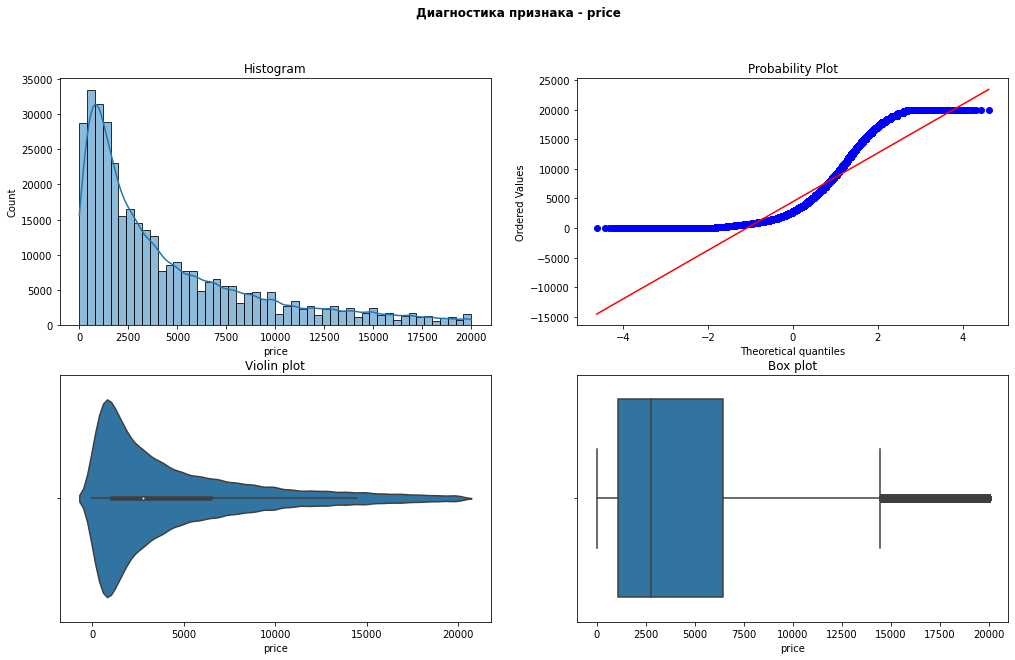

Уникальные значения "price":


,0,1,2,3,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,24,25,26,27,29,...,19880,19888,19890,19899,19900,19911,19935,19945,19949,19950,19960,19968,19970,19975,19980,19985,19986,19987,19989,19990,19995,19997,19998,19999,20000
price,10039,1073,11,6,24,2,1,6,73,3,6,6,4,22,1,5,3,2,39,1,1,26,1,1,2,...,3,1,12,5,388,3,2,2,1,79,1,1,3,1,19,2,1,2,1,178,10,1,6,278,266



Статистические показатели:


,5_quantile,95_quantile,min,median,max
price,200.0,14681.6,0,2750.0,20000


In [24]:
analysis_plots(df, 'price')

Данные распределены ассиметрично с длинным хвостом в сторону увеличения цены. Максимальное значение 20_000, оно может соотвествовать реальности, но околонулевые значения не соотвествуют реальной стоимости, и являются явными аномалиями.

In [25]:
print('Проверим долю выборки без 5% квантиля:', round(df[df.price < 200].shape[0] / df.shape[0], 3))

Проверим долю выборки без 5% квантиля: 0.046


In [26]:
display(df[df.price == 200].head())

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
60,2016-03-26 07:54:29,200,coupe,1995,manual,102,3er,150000,4,petrol,bmw,unknown,2016-03-26 00:00:00,0,23560,2016-04-01 20:46:51
469,2016-03-14 06:03:08,200,small,1995,manual,60,ibiza,150000,10,petrol,seat,no,2016-03-14 00:00:00,0,14542,2016-03-17 20:16:30
545,2016-03-16 07:53:35,200,sedan,1995,manual,55,golf,150000,0,petrol,volkswagen,unknown,2016-03-16 00:00:00,0,6842,2016-04-06 02:44:22
783,2016-03-30 13:58:08,200,small,2005,auto,58,twingo,150000,1,petrol,renault,yes,2016-03-30 00:00:00,0,50667,2016-04-01 08:18:17
862,2016-03-31 15:46:25,200,sedan,1995,manual,102,3er,150000,8,petrol,bmw,unknown,2016-03-31 00:00:00,0,6667,2016-03-31 15:46:25


Авто стоимостью 200 евро, в основном старые авто, либо авто после ремонтных работ(возможно битые).

Удалим 5% квантиль из выборки, как данные несоотвествующие действительности.

In [27]:
df = df[df.price >= 200]
share_sample_print(df, data)

Остаток выборки - 335765 
Доля от общей выборки 0.948


Проанализируем признак `power`

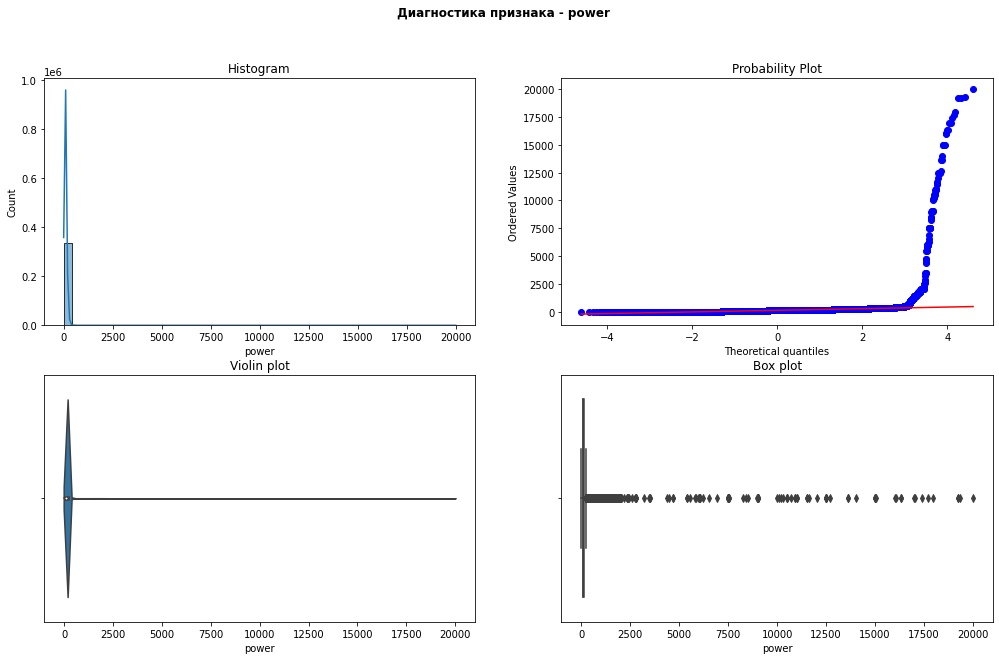

Уникальные значения "power":


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,11635,12012,12510,12512,12684,13616,13636,14009,15001,15017,15020,15033,16011,16051,16311,16312,17011,17019,17410,17700,17932,19208,19211,19312,20000
power,32649,22,9,9,30,99,10,10,7,5,12,28,18,7,20,17,11,8,50,14,19,6,5,42,28,...,1,1,2,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1



Статистические показатели:


,5_quantile,95_quantile,min,median,max
power,0.0,218.0,0,105.0,20000


In [28]:
analysis_plots(df, 'power')

Данные на графиках явно искажены аномалиями. Для проведения корректного анализ проверим явные аномалии ввиде мощности 0 или не входящии в диапазон *25 - 500 л.с.* Таких двигателей на рынке не существует либо в очень редких случаях и явно указывает на то, что это некорректные данные. При таких значительных аномалиях мы не можем ориентироваться только на 5% квантили, т.к. нижний диапазон 0 из-за большого значения объектов равных 0, а верхний *228 л.с.* не достаточно высокий, т.к. существуют автомобили до *500 л.с.* в достаточном количестве. Посмотрим какой объем данных и их качество.

In [29]:
power_mask = (df.power < 25) | (df.power > 500)
display(f'Количество - {df[power_mask].shape[0]}', f'Доля - {round(df[power_mask].shape[0] / df.shape[0], 2)}')

'Количество - 33549'

'Доля - 0.1'

In [30]:
display(df[power_mask].sample(5))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
205597,2016-03-12 15:41:47,10500,wagon,2007,manual,0,3er,150000,8,gasoline,bmw,no,2016-03-12 00:00:00,0,32361,2016-03-19 16:50:03
111013,2016-03-21 01:56:46,1699,small,2003,manual,0,other,150000,1,petrol,peugeot,no,2016-03-21 00:00:00,0,12437,2016-03-28 01:18:05
246923,2016-04-03 21:51:13,6900,small,2008,manual,0,megane,20000,11,petrol,renault,unknown,2016-04-03 00:00:00,0,30459,2016-04-05 23:15:26
40118,2016-03-17 11:25:22,2700,wagon,2017,manual,0,caddy,150000,8,gasoline,volkswagen,no,2016-03-17 00:00:00,0,56073,2016-03-17 14:46:10
350589,2016-03-31 22:49:43,4800,sedan,2005,manual,0,a3,150000,12,gasoline,audi,unknown,2016-03-31 00:00:00,0,53819,2016-04-06 19:45:45


Разные авто в большом количестве почти 10% от текущей выборки с аномальными значениями, если удалим (учитыва то, что ранее удалили и удалим далее), то можем потяреть важные для дальнейшего исследования данные. Т.к. мощность двигателя имеет примерно одинаковые объемы в разрезе моделей одного бренда, в разрезе годов, заменим медианными значениями сгруппированных моделей по годам и брендам. 

In [31]:
df.loc[power_mask, 'power'] = np.nan
df.power = df.power.fillna(df.groupby(['model', 'brand','registration_year'])['power'].transform('median'))
print('Пустых значений в power -', df.power.isna().sum())

Пустых значений в power - 564


In [32]:
display(df[df.power.isna()].sample(5))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
14572,2016-03-10 21:51:00,950,wagon,2000,manual,NaN,lancer,150000,2,petrol,mitsubishi,no,2016-03-10 00:00:00,0,79100,2016-03-12 14:46:10
346731,2016-04-01 21:53:29,11000,suv,1950,manual,NaN,other,5000,6,petrol,chevrolet,no,2016-04-01 00:00:00,0,79098,2016-04-05 20:18:28
30644,2016-03-29 10:51:56,300,wagon,1995,other,NaN,v70,150000,0,petrol,volvo,yes,2016-03-29 00:00:00,0,47443,2016-03-31 03:15:51
166560,2016-03-18 00:55:49,9200,convertible,1969,manual,NaN,500,100000,6,petrol,fiat,no,2016-03-17 00:00:00,0,38100,2016-04-05 21:18:28
229696,2016-03-07 19:41:32,200,sedan,2016,auto,NaN,other,5000,0,petrol,jaguar,yes,2016-03-07 00:00:00,0,46049,2016-04-07 09:45:16


In [33]:
#Удалим строки с данными мощности которые невозможно вычислить
df = df.dropna()
display(df.isna().sum())

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

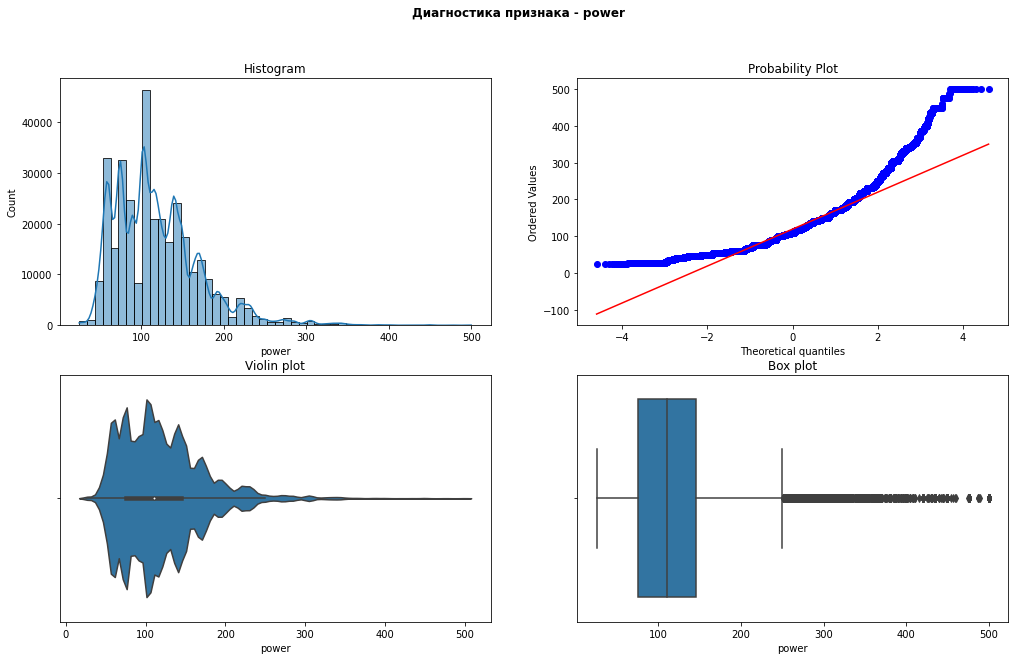

Уникальные значения "power":


,25.0,26.0,27.0,28.0,29.0,30.0,31.0,31.5,32.0,33.0,34.0,35.0,36.0,36.5,37.0,38.0,39.0,39.5,40.0,40.5,41.0,41.5,42.0,42.5,43.0,...,411.0,416.0,420.0,421.0,425.0,426.0,428.0,430.0,431.0,435.0,440.0,442.0,445.0,449.0,450.0,454.0,457.0,459.0,460.0,475.0,476.0,487.0,489.0,490.0,500.0
power,17,390,41,6,35,41,10,2,3,50,221,10,9,6,45,24,130,9,280,2,441,5,54,4,111,...,2,1,23,2,1,2,1,3,4,34,3,1,11,1,82,1,1,1,1,1,31,2,1,1,36



Статистические показатели:


,5_quantile,95_quantile,min,median,max
power,54.0,218.0,25.0,110.0,500.0


In [34]:
analysis_plots(df, 'power')

In [35]:
share_sample_print(df, data)

Остаток выборки - 335201 
Доля от общей выборки 0.946


Теперь данные отображают более реальную картину и мы сохранили большую часть выборки

Проанализируем признак `kilometer`

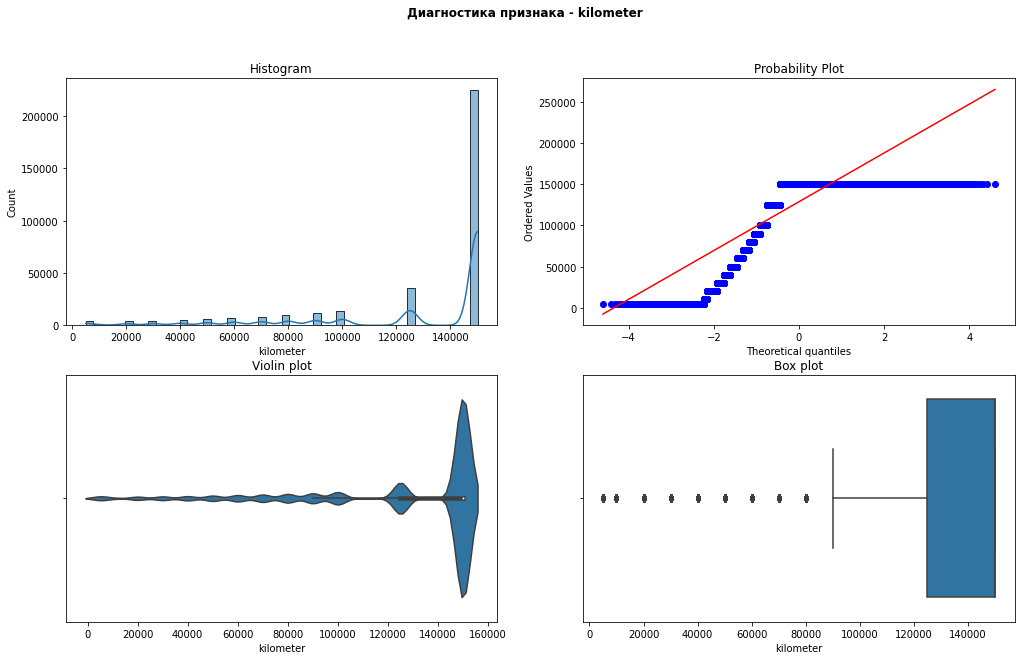

Уникальные значения "kilometer":


,5000,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,125000,150000
kilometer,4213,1033,3689,4255,4817,6086,7301,8399,9793,11279,14094,35253,224989



Статистические показатели:


,5_quantile,95_quantile,min,median,max
kilometer,40000.0,150000.0,5000,150000.0,150000


In [36]:
analysis_plots(df, 'kilometer')

In [37]:
print(np.sort(df[df.kilometer == 5000].registration_year.unique()))

[1000 1500 1800 1910 1927 1929 1935 1937 1943 1944 1950 1951 1952 1955
 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969
 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983
 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2800 2900 4000 4500 5000]


Как и предполагали в данных нет явных аномалий в пробеге авто, большинство из них сконцентрированны в районе 150_000 км., что может говорить о том, что это предельный пробег (к примеру более 150_000 км.) и скорее всего установлен указанный диапазон значений (выбор галочкой указанного пробега), поэтому нет менее 5000 км и данные сгрупированны в определенных цифрах.

Как ранее уже было отмечено, надо обратить внимание на наличие в годе производства авто странные года.

Проанализируем признак `registration_year`

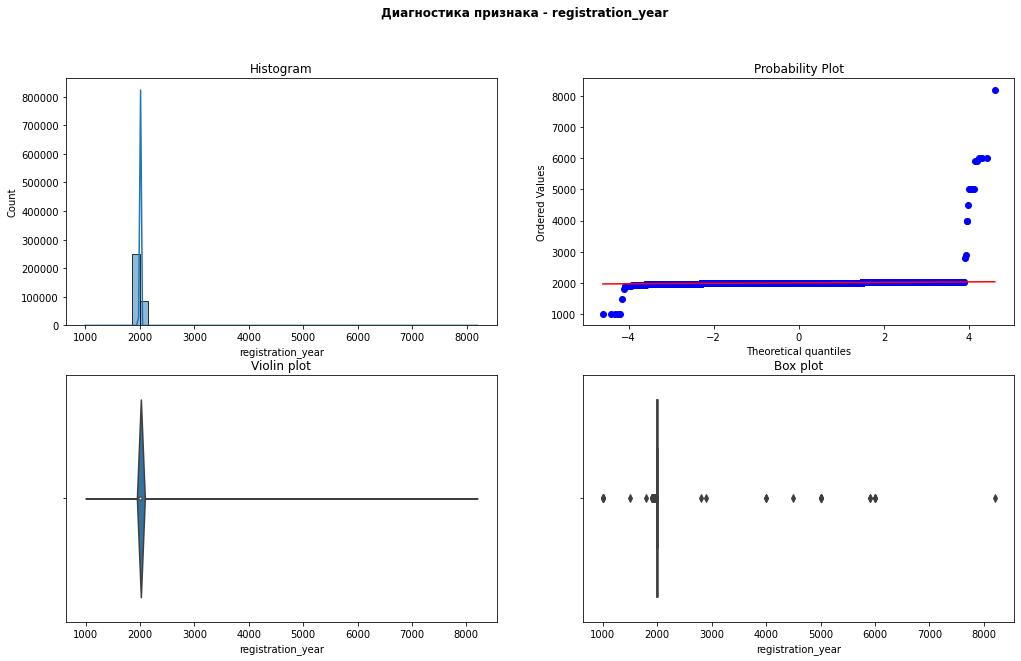

Уникальные значения "registration_year":


,1000,1500,1800,1910,1927,1928,1929,1931,1935,1937,1938,1941,1942,1943,1944,1945,1947,1948,1949,1950,1951,1952,1953,1954,1955,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2800,2900,4000,4500,5000,5911,6000,8200
registration_year,5,1,1,7,1,1,3,1,1,8,1,1,2,4,2,2,1,2,1,9,9,6,11,6,12,...,19441,19286,21138,19618,16960,15210,14353,10633,9802,7092,4066,2473,1093,8413,9698,3701,8,1,1,2,1,5,2,3,1



Статистические показатели:


,5_quantile,95_quantile,min,median,max
registration_year,1993.0,2016.0,1000,2003.0,8200


In [38]:
analysis_plots(df, 'registration_year')

Графики в таком маштабе не читабельны, актуальный год производста авто нам необходим для дальнейшего расчета "возраста" автомобиля, поэтому отберем актуальные для анализа года. Отбросить данные по 5% квантилям, будет не свосем корректно, по карйне мерее относительно нижнего предела, т.к. есть высокая вероятность того, что на рынке присутвовали в необльшом количестве автомобили старше 1993 года, поэтому рассмотрим количество автомобилей прошлого периода. Верхний предел оставим на уровне 95% квантиля, т.к. 2016 год совпадает актуальному году анализа.

Для анализа актуальности дат отсечем года менее 1910, т.к. только после этой даты начался развиваться автопром

In [39]:
print(np.sort(df.query('registration_year < 1993 & registration_year > 1900')
              .registration_year
              .value_counts()
              .index.unique()))

[1910 1927 1928 1929 1931 1935 1937 1938 1941 1942 1943 1944 1945 1947
 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961
 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992]


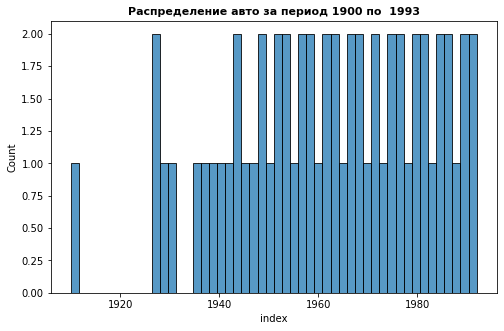

In [40]:
plt.subplots(figsize=(8, 5))
sns.histplot(df
             .query('registration_year > 1900 & registration_year < 1993')
             .registration_year
             .value_counts()
             .reset_index()['index'], bins=50)
plt.title('Распределение авто за период 1900 по  1993', fontweight='bold', fontsize = 11)
plt.show()

Примем нижний предел `1940` год, с этого года производства авто в наличии в базе без отсутвующих значений, что говорит о наличии в достаточном количестве авто на рынке и соотвественно более маштабного производства авто.  

In [41]:
df = df[(df.registration_year > 1939) & (df.registration_year < 2016)]

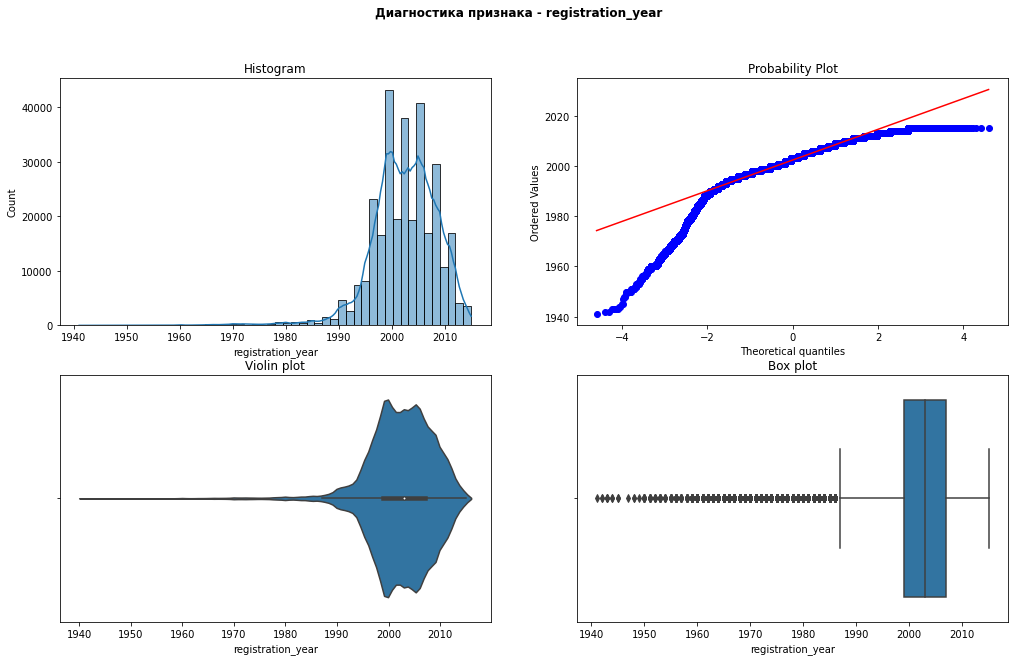

Уникальные значения "registration_year":


,1941,1942,1943,1944,1945,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
registration_year,1,2,4,2,2,1,2,1,9,9,6,11,6,12,20,10,14,27,82,28,31,52,54,69,103,...,2506,2730,3072,4346,8068,9858,13336,16589,21519,21665,19478,18631,19441,19286,21138,19618,16960,15210,14353,10633,9802,7092,4066,2473,1093



Статистические показатели:


,5_quantile,95_quantile,min,median,max
registration_year,1993.0,2011.0,1941,2003.0,2015


In [42]:
analysis_plots(df, 'registration_year')

In [43]:
share_sample_print(df, data)

Остаток выборки - 313335 
Доля от общей выборки 0.884


Проанализируем признак `postal_code`

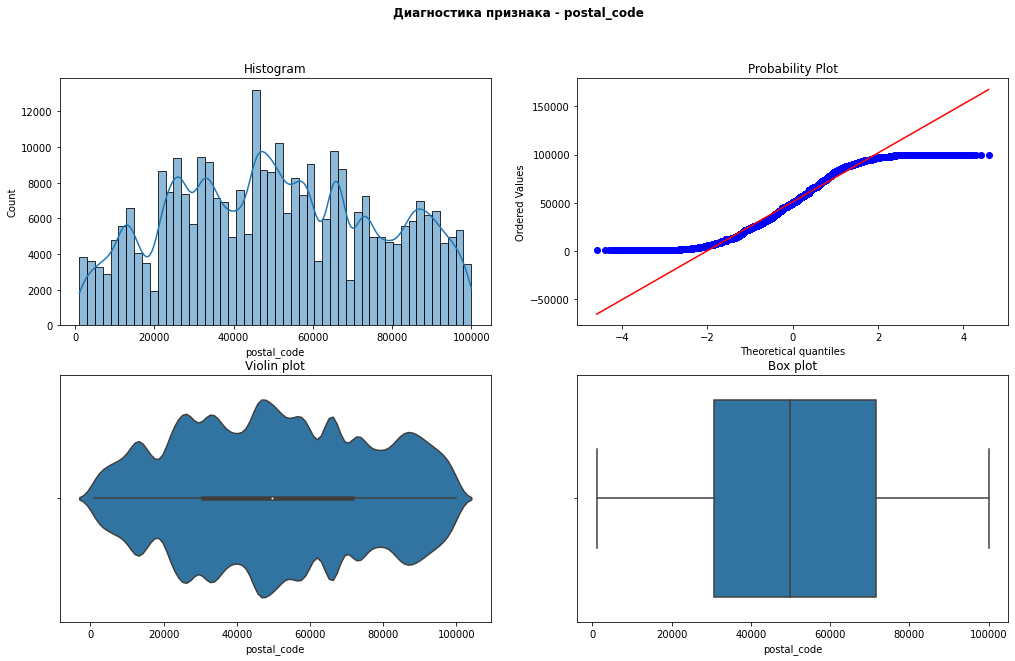

Уникальные значения "postal_code":


,1067,1068,1069,1097,1099,1108,1109,1127,1129,1139,1156,1157,1159,1169,1187,1189,1217,1219,1237,1239,1257,1259,1277,1279,1307,...,99834,99837,99842,99846,99848,99867,99869,99880,99885,99887,99891,99894,99897,99898,99947,99955,99958,99974,99976,99986,99988,99991,99994,99996,99998
postal_code,89,1,51,26,57,11,65,25,37,53,35,69,80,21,34,29,40,28,28,27,40,37,70,34,38,...,12,10,28,6,20,159,53,32,28,13,6,29,20,1,57,17,8,134,30,15,8,2,6,2,13



Статистические показатели:


,5_quantile,95_quantile,min,median,max
postal_code,10115.0,93098.0,1067,49751.0,99998


In [44]:
analysis_plots(df, 'postal_code')

В целом данные распределены равномерно по почтовым индексам, с признаками нормального распределения, с уменьшением значений на минимумах и максимумах. 

### Features selection

#### Создадим новый признаки на основе не информативных признаков

Расчитаем срок эксплуотации авто, назовем признак `car_age`, который будет хранить возраст авто, а так же расчитаем количество дне от первого дня объявления в выборке. Т.к. предположительно возраст автомобиля должен оказывать критичное влияние на цену.

In [45]:
first_date = pd.Timestamp(df.date_created.min())
print(first_date)

2014-03-10 00:00:00


In [46]:
df.loc[:, 'car_age'] = pd.Timestamp(df.date_created.max()).year - df.registration_year

Так заменим значени в date_created на количество дней от даты с которой делалась выгрузка (2014 г.) до даты создания акнеты. Этот признак будет определять разницу во времени между размещениями объявлений. Т.к. есть вероятность того, что от этого может зависить стоимость.

In [47]:
df.date_created = df.date_created.apply(lambda date: (pd.Timestamp(date) - first_date).days)
display(df.head())

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,car_age
0,2016-03-24 11:52:17,480,sedan,1993,manual,90.0,golf,150000,0,petrol,volkswagen,unknown,745,0,70435,2016-04-07 03:16:57,23
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.0,other,125000,5,gasoline,audi,yes,745,0,66954,2016-04-07 01:46:50,5
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,unknown,735,0,90480,2016-04-05 12:47:46,12
3,2016-03-17 16:54:04,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,738,0,91074,2016-03-17 17:40:17,15
4,2016-03-31 17:25:20,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,752,0,60437,2016-04-06 10:17:21,8


#### Проверим взаимосвязь через корреляцию признаков

In [48]:
#отрисовка графика
def plot_helper(data, kind, plot_name, ylabel, xlabel):
    data.plot(kind=kind,
              figsize=(12, 6), 
              grid=True,  
              rot=40)
    plt.title(plot_name, fontweight='bold')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

In [49]:
#создадим маску с категориальными колонками
mask_num = [i for i in df.dtypes.index if df.dtypes[i] != 'object']

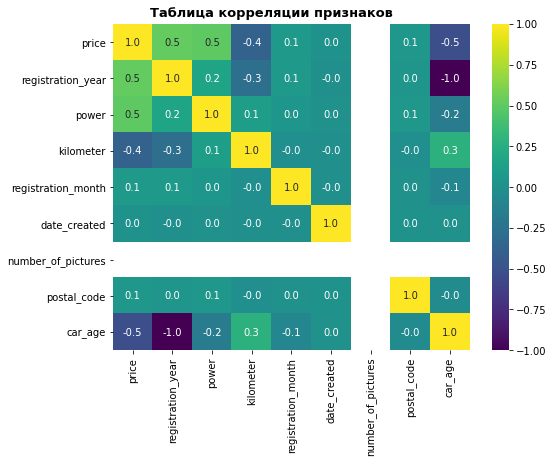

In [50]:
plt.figure(figsize = (8, 6))
sns.heatmap(
    data=df[mask_num].corr(), 
    annot=True, fmt='0.1f', cmap='viridis')
plt.suptitle(f'Таблица корреляции признаков', 
             fontweight='bold',
             fontsize = 13,
             y = 0.92, x=0.4)
plt.show()


Мультиколлинеарности в непрерывных признаках не наблюдается, отметим линейную зависимость `power` `registration_year`, и обратную зависимость `kilometer`, `car_age`. 

#### Проверим статистику взаимной информации

Для начала удалим не нужные в дальнейшем исследовании признаки, которые определили на данный момент:
- `date_crawled` - не информативные для моделей обучения данные
- `registration_month` - не информативные для моделей обучения данные
- `number_of_pictures` - отсутствуют данные
- `last_seen` - не информативные для моделей обучения данные

In [51]:
df = df.drop(['date_crawled', 
              'registration_month', 
              'number_of_pictures', 
              'last_seen'], axis=1)
display(df.head(3))

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created,postal_code,car_age
0,480,sedan,1993,manual,90.0,golf,150000,petrol,volkswagen,unknown,745,70435,23
1,18300,coupe,2011,manual,190.0,other,125000,gasoline,audi,yes,745,66954,5
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown,735,90480,12


In [52]:
%%time
ce_count_encoder = CountEncoder()
data_count_enc = ce_count_encoder.fit_transform(df[df.columns.difference(['price'])])
display(data_count_enc.head())

,brand,car_age,date_created,fuel_type,gearbox,kilometer,model,postal_code,power,registration_year,repaired,vehicle_type
0,67084,23,745,211145,240047,150000,25297,70435,90.0,1993,51494,92001
1,26833,5,745,96322,240047,125000,34810,66954,190.0,2011,29868,15649
2,616,12,735,96322,61681,125000,539,90480,163.0,2004,51494,11891
3,67084,15,738,211145,240047,150000,25297,91074,75.0,2001,231973,77886
4,5169,8,752,96322,240047,90000,1970,60437,69.0,2008,231973,77886


CPU times: user 1.97 s, sys: 128 ms, total: 2.09 s
Wall time: 2.11 s


In [53]:
#обновим маску с категориальными колонками
mask_num = [i for i in data_count_enc.dtypes.index if data_count_enc.dtypes[i] != 'object']

In [54]:
#маштабируем признаки, для методов SelectKBest, mutual_info_regression
scaler = StandardScaler()
data_count_enc.loc[:, mask_num] = scaler.fit_transform(data_count_enc[mask_num])
display(data_count_enc.head())

,brand,car_age,date_created,fuel_type,gearbox,kilometer,model,postal_code,power,registration_year,repaired,vehicle_type
0,1.662,1.474,0.341,0.680,0.549,0.586,1.349,0.758,-0.574,-1.474,-1.589,0.986
1,-0.159,-1.356,0.341,-1.313,0.549,-0.089,2.200,0.623,1.319,1.356,-1.850,-1.767
2,-1.345,-0.255,-0.721,-1.313,-1.699,-0.089,-0.868,1.537,0.808,0.255,-1.589,-1.903
3,1.662,0.216,-0.403,0.680,0.549,0.586,1.349,1.560,-0.858,-0.216,0.591,0.477
4,-1.139,-0.884,1.085,-1.313,0.549,-1.035,-0.740,0.370,-0.971,0.884,0.591,0.477


In [55]:
%%time
sel_mut_info = SelectKBest(mutual_info_regression, k=5).fit(data_count_enc, df.price)
display(pd.DataFrame(data =[sel_mut_info.get_support()], columns=data_count_enc.columns))

,brand,car_age,date_created,fuel_type,gearbox,kilometer,model,postal_code,power,registration_year,repaired,vehicle_type
0,False,True,False,False,False,False,True,True,True,True,False,False


CPU times: user 56.6 s, sys: 143 ms, total: 56.8 s
Wall time: 57.1 s


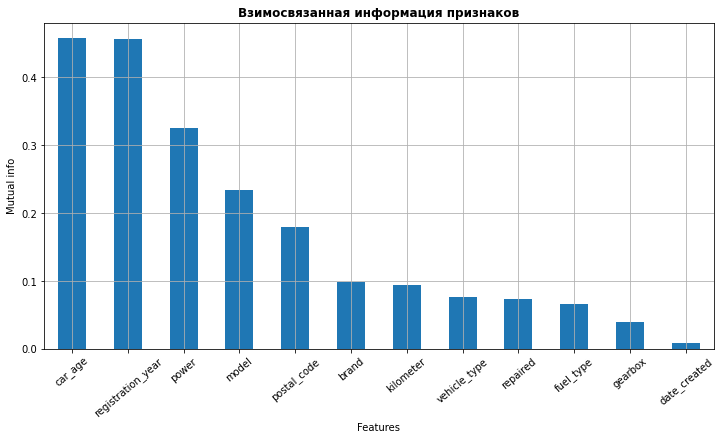

CPU times: user 54.6 s, sys: 181 ms, total: 54.8 s
Wall time: 54.8 s


In [56]:
%%time
mut_info = mutual_info_regression(data_count_enc, df.price)
mut_info = pd.Series(mut_info, index=data_count_enc.columns).sort_values(ascending=False)
plot_helper(mut_info, 'bar', 'Взимосвязанная информация признаков', 'Mutual info', 'Features')

Возраст и мощность авто играет ключевую роль в предсказаниях цены. А вот количество дней от первого дня выборки до размещения объявления показывает очень низкое предсказание и его удалим.  

Признаки `fuel_type`, `gearbox`, так же показывают слабую взаимосвязь, что и логично по сравнению с другими признаками фактор типа топлива и коробки передач не такой существенный в ценообразовании б/у авто.

In [57]:
df = df.drop(['date_created', 'fuel_type', 'gearbox'], axis=1)
print(df.columns)

Index(['price', 'vehicle_type', 'registration_year', 'power', 'model',
       'kilometer', 'brand', 'repaired', 'postal_code', 'car_age'],
      dtype='object')


### Подготовка данных для обучения моделей

#### Деление выборки на train, valid, test

Поделим выборку на тренировочную, валидационную и тестовую

In [58]:
features = df.drop('price', axis=1)
target = df.price

In [59]:
X_train_all, X_test, y_train_all, y_test = train_test_split(features, target, 
                                                            test_size=0.20, 
                                                            random_state=STATE)

In [60]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, 
                                                      test_size=0.25, 
                                                      random_state=STATE)

In [61]:
display(pd.DataFrame(
    {'sample_type':['test_sample', 'train_sample', 'validation_sample'],
     'target': [y_test.shape[0], 
                y_train.shape[0], 
                y_valid.shape[0]],
     'features': [X_test.shape[0],
                  X_train.shape[0],
                  X_valid.shape[0]],
     'share': [y_test.shape[0] / features.shape[0], 
               y_train.shape[0] / features.shape[0],
               y_valid.shape[0] / features.shape[0]]
    }))

,sample_type,target,features,share
0,test_sample,62667,62667,0.2
1,train_sample,188001,188001,0.6
2,validation_sample,62667,62667,0.2


In [62]:
#категориальные столбцы
mask_category = [i for i in features.dtypes.index if features.dtypes[i] == 'object']
#обновим числовые столбцы
mask_num = [i for i in features.dtypes.index if features.dtypes[i] != 'object']

#### Кодирование категориальных признаков

Кодирование категориальных признаков
ядковых методов кодирования.
1
Закодируем 'vehicle_type', 'model', 'brand' с помощью CountEncoder, чтоб не увеличивать количество столбцов и не зависить от порядковых методов кодирования.

In [63]:
ce_count_encoder = CountEncoder(cols=mask_category[:-1], normalize=True)
ce_count_encoder.fit(X_train)

CountEncoder(cols=['vehicle_type', 'model', 'brand'],
             combine_min_nan_groups=True, normalize=True)

In [64]:
X_train_encoder = ce_count_encoder.transform(X_train)
X_train_all_encoder = ce_count_encoder.transform(X_train_all)
X_valid_encoder = ce_count_encoder.transform(X_valid)
X_test_encoder = ce_count_encoder.transform(X_test)
display(X_train_encoder.head())

,vehicle_type,registration_year,power,model,kilometer,brand,repaired,postal_code,car_age
282765,0.063,2001,109.0,0.014,125000,0.032,no,67071,15
274521,0.092,2011,90.0,0.002,70000,0.048,no,66578,5
193273,0.293,2004,150.0,0.058,150000,0.107,unknown,42289,12
130012,0.204,2003,170.0,0.058,150000,0.107,no,48480,13
14305,0.038,1984,156.0,0.111,125000,0.005,no,38100,32


In [65]:
ce_ohe = OneHotEncoder()
ce_ohe.fit(X_train_encoder)

OneHotEncoder(cols=['repaired'])

In [66]:
X_train_encoder = ce_ohe.transform(X_train_encoder)
X_train_all_encoder = ce_ohe.transform(X_train_all_encoder)
X_valid_encoder = ce_ohe.transform(X_valid_encoder)
X_test_encoder = ce_ohe.transform(X_test_encoder)

переобучим наш scaler без лишних столбцов

In [67]:
scaler.fit(X_train_encoder[mask_num])
X_train_encoder.loc[:, mask_num] = scaler.transform(X_train_encoder[mask_num])
X_train_all_encoder.loc[:, mask_num] = scaler.transform(X_train_all_encoder[mask_num])
X_valid_encoder.loc[:, mask_num] = scaler.transform(X_valid_encoder[mask_num])
X_test_encoder.loc[:, mask_num] = scaler.transform(X_test_encoder[mask_num])
display(X_valid_encoder.head())

,vehicle_type,registration_year,power,model,kilometer,brand,repaired_1,repaired_2,repaired_3,postal_code,car_age
101766,0.050,-0.532,-0.287,0.058,0.586,0.107,1,0,0,1.299,0.532
235510,0.249,-1.161,-0.477,0.004,0.586,0.032,1,0,0,-1.812,1.161
56305,0.092,-0.060,0.470,0.003,0.586,0.069,0,0,1,1.272,0.060
217207,0.293,-7.296,-1.423,0.111,-0.769,0.109,1,0,0,-0.564,7.296
324423,0.063,1.513,-0.344,0.111,-1.852,0.048,1,0,0,0.561,-1.513


Изменим тип object на category в данных для обучении на LGBMRegressor

In [68]:
X_train.loc[:, mask_category] = X_train[mask_category].astype('category')
X_valid.loc[:, mask_category] = X_valid[mask_category].astype('category')
X_train_all.loc[:, mask_category] = X_train_all[mask_category].astype('category')
X_test.loc[:, mask_category] = X_test[mask_category].astype('category')
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62667 entries, 101766 to 14599
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   vehicle_type       62667 non-null  category
 1   registration_year  62667 non-null  int64   
 2   power              62667 non-null  float64 
 3   model              62667 non-null  category
 4   kilometer          62667 non-null  int64   
 5   brand              62667 non-null  category
 6   repaired           62667 non-null  category
 7   postal_code        62667 non-null  int64   
 8   car_age            62667 non-null  int64   
dtypes: category(4), float64(1), int64(4)
memory usage: 3.2 MB


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


Данные готовы к дальнейшему использования при помощи моделей

## Обучение моделей

In [69]:
#функция для mse оценки
def rsme_score(target, pred):
    return mean_squared_error(target, pred)**0.5 

rsme_sc = make_scorer(rsme_score, greater_is_better=False)

In [70]:
#функция для получения модели
def find_model(regressor, feature, target, param={}):
    start_time = time.time()
    clf = GridSearchCV(
        estimator=regressor, 
        param_grid = param, 
        #cv = 5, 
        n_jobs=-1,
        scoring= rsme_sc)    
    
    clf.fit(feature, target)
    fit_time = time.time() - start_time
    
    print(f'{clf.best_estimator_.__class__.__name__} train RSME -', -1 * clf.best_score_)
    print('Время на подбор параметров -', round(fit_time, 2), 'секунд')
   
    return clf.best_estimator_, clf.best_params_

In [71]:
#обучение и предсказие и получение время и оценки
def get_result(model, feature_train, feature_valid, target_train, target_valid):
    start_time = time.time()
    model.fit(feature_train, target_train)
    fit_time = round(time.time() - start_time, 2)
    
    start_time = time.time()
    predicts = model.predict(feature_valid)
    pred_time = round(time.time() - start_time, 2)
    
    rsme = round(rsme_score(target_valid, predicts), 2)
    return [model.__class__.__name__, fit_time, pred_time, rsme]
  

In [72]:
#создадим датафрейм с результатом
df_res = pd.DataFrame(columns=['model', 'time_fit', 'time_prediction', 'rsme'])
display(df_res)

,model,time_fit,time_prediction,rsme


**LinearRegression:**

In [73]:
model_lr, _ = find_model(LinearRegression(), X_train_encoder, y_train)
model_lr, _

LinearRegression train RSME - 2913.8779684381725
Время на подбор параметров - 1.03 секунд


(LinearRegression(), {})

In [74]:
df_res.loc[df_res.shape[0]] = get_result(model_lr, X_train_encoder, X_valid_encoder, y_train, y_valid)
display(df_res)

,model,time_fit,time_prediction,rsme
0,LinearRegression,0.18,0.01,2924.77


Результат rsme линейно модели 2925, справляется плохо, посомтрим, что другие модели покажут. 

**LGBMRegressor:**

In [75]:
%%time
model_lgbm = LGBMRegressor(n_estimators=800, max_depth=6, learning_rate=.1, random_state=STATE)
df_res.loc[df_res.shape[0]] = get_result(model_lgbm, X_train, X_valid, y_train, y_valid)
display(df_res)

,model,time_fit,time_prediction,rsme
0,LinearRegression,0.18,0.01,2924.77
1,LGBMRegressor,22.20,7.23,1567.08


CPU times: user 29 s, sys: 199 ms, total: 29.2 s
Wall time: 29.5 s


**DecisionTreeRegressor:**

In [76]:
tree_params = {
    'max_depth': [14, 15],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [2, 3]
}
model_dtr, param_dtr = find_model(
    DecisionTreeRegressor(random_state=STATE), X_train_encoder, y_train, tree_params)

df_res.loc[df_res.shape[0]] = get_result(model_dtr, X_train_encoder, X_valid_encoder, y_train, y_valid)
df_res

DecisionTreeRegressor train RSME - 1876.2680733279692
Время на подбор параметров - 23.77 секунд


,model,time_fit,time_prediction,rsme
0,LinearRegression,0.18,0.01,2924.77
1,LGBMRegressor,22.20,7.23,1567.08
2,DecisionTreeRegressor,0.72,0.01,1834.43


**KNeighborsRegressor:**

In [77]:
%%time
knn_param = {'n_neighbors' : [14, 15, 16]}
model_knn, param__knn = find_model(KNeighborsRegressor(), X_train_encoder, y_train, param=knn_param)

df_res.loc[df_res.shape[0]] = get_result(model_knn, X_train_encoder, X_valid_encoder, y_train, y_valid)
display(df_res)

KNeighborsRegressor train RSME - 2048.523175357149
Время на подбор параметров - 60.54 секунд


,model,time_fit,time_prediction,rsme
0,LinearRegression,0.18,0.01,2924.77
1,LGBMRegressor,22.20,7.23,1567.08
2,DecisionTreeRegressor,0.72,0.01,1834.43
3,KNeighborsRegressor,2.09,5.05,2046.03


CPU times: user 1min 7s, sys: 129 ms, total: 1min 7s
Wall time: 1min 7s


**CatBoostRegressor:**

In [78]:
model_cat_boots = CatBoostRegressor(iterations=500, learning_rate=0.5, max_depth=10)
df_res.loc[df_res.shape[0]] = get_result(model_cat_boots, X_train_encoder, X_valid_encoder, y_train, y_valid)
display(df_res)

0:	learn: 3027.5718440	total: 115ms	remaining: 57.6s
1:	learn: 2364.9230138	total: 171ms	remaining: 42.6s
2:	learn: 2066.5117714	total: 232ms	remaining: 38.4s
3:	learn: 1955.3439431	total: 286ms	remaining: 35.5s
4:	learn: 1899.8334407	total: 340ms	remaining: 33.7s
5:	learn: 1848.8576552	total: 397ms	remaining: 32.7s
6:	learn: 1814.7577660	total: 449ms	remaining: 31.7s
7:	learn: 1796.4235472	total: 504ms	remaining: 31s
8:	learn: 1781.9224071	total: 559ms	remaining: 30.5s
9:	learn: 1763.0201927	total: 614ms	remaining: 30.1s
10:	learn: 1748.8938425	total: 671ms	remaining: 29.8s
11:	learn: 1733.1827512	total: 724ms	remaining: 29.4s
12:	learn: 1721.6650478	total: 776ms	remaining: 29.1s
13:	learn: 1710.5438784	total: 829ms	remaining: 28.8s
14:	learn: 1705.3886874	total: 884ms	remaining: 28.6s
15:	learn: 1699.6517176	total: 939ms	remaining: 28.4s
16:	learn: 1691.9442563	total: 992ms	remaining: 28.2s
17:	learn: 1684.5331913	total: 1.04s	remaining: 27.9s
18:	learn: 1678.2496680	total: 1.09s	rem

153:	learn: 1370.3517048	total: 8.47s	remaining: 19s
154:	learn: 1368.8894074	total: 8.52s	remaining: 19s
155:	learn: 1367.8849183	total: 8.57s	remaining: 18.9s
156:	learn: 1367.2196424	total: 8.62s	remaining: 18.8s
157:	learn: 1366.7658244	total: 8.68s	remaining: 18.8s
158:	learn: 1365.5432165	total: 8.73s	remaining: 18.7s
159:	learn: 1364.2846713	total: 8.78s	remaining: 18.7s
160:	learn: 1363.1039353	total: 8.84s	remaining: 18.6s
161:	learn: 1362.5486974	total: 8.89s	remaining: 18.6s
162:	learn: 1361.2652972	total: 8.95s	remaining: 18.5s
163:	learn: 1360.5681345	total: 9s	remaining: 18.4s
164:	learn: 1359.6447781	total: 9.06s	remaining: 18.4s
165:	learn: 1358.7646212	total: 9.12s	remaining: 18.3s
166:	learn: 1358.0038364	total: 9.17s	remaining: 18.3s
167:	learn: 1357.2092502	total: 9.23s	remaining: 18.2s
168:	learn: 1355.5676218	total: 9.29s	remaining: 18.2s
169:	learn: 1354.1901235	total: 9.34s	remaining: 18.1s
170:	learn: 1353.3333270	total: 9.4s	remaining: 18.1s
171:	learn: 1351.9

305:	learn: 1243.9828886	total: 16.9s	remaining: 10.7s
306:	learn: 1242.7370022	total: 17s	remaining: 10.7s
307:	learn: 1242.1908271	total: 17s	remaining: 10.6s
308:	learn: 1241.2169001	total: 17.1s	remaining: 10.6s
309:	learn: 1240.9488673	total: 17.1s	remaining: 10.5s
310:	learn: 1240.4797654	total: 17.2s	remaining: 10.5s
311:	learn: 1239.9314229	total: 17.3s	remaining: 10.4s
312:	learn: 1238.6003119	total: 17.3s	remaining: 10.3s
313:	learn: 1238.2237639	total: 17.4s	remaining: 10.3s
314:	learn: 1237.7205166	total: 17.4s	remaining: 10.2s
315:	learn: 1236.9808298	total: 17.5s	remaining: 10.2s
316:	learn: 1236.5624082	total: 17.5s	remaining: 10.1s
317:	learn: 1235.8223419	total: 17.6s	remaining: 10.1s
318:	learn: 1235.5507356	total: 17.6s	remaining: 10s
319:	learn: 1235.1510911	total: 17.7s	remaining: 9.96s
320:	learn: 1234.6936493	total: 17.8s	remaining: 9.9s
321:	learn: 1234.1258634	total: 17.8s	remaining: 9.84s
322:	learn: 1233.7382248	total: 17.9s	remaining: 9.79s
323:	learn: 1232.

456:	learn: 1166.3205008	total: 25.3s	remaining: 2.38s
457:	learn: 1165.7139533	total: 25.4s	remaining: 2.33s
458:	learn: 1164.9286914	total: 25.5s	remaining: 2.28s
459:	learn: 1164.6907324	total: 25.6s	remaining: 2.23s
460:	learn: 1164.2215777	total: 25.7s	remaining: 2.17s
461:	learn: 1163.7740836	total: 25.8s	remaining: 2.12s
462:	learn: 1163.2082506	total: 25.9s	remaining: 2.07s
463:	learn: 1163.0092921	total: 25.9s	remaining: 2.01s
464:	learn: 1162.7791633	total: 26s	remaining: 1.96s
465:	learn: 1162.3772824	total: 26s	remaining: 1.9s
466:	learn: 1162.0191312	total: 26.1s	remaining: 1.84s
467:	learn: 1161.5956284	total: 26.2s	remaining: 1.79s
468:	learn: 1161.2921745	total: 26.2s	remaining: 1.73s
469:	learn: 1161.0235429	total: 26.3s	remaining: 1.68s
470:	learn: 1160.7340831	total: 26.3s	remaining: 1.62s
471:	learn: 1159.9799805	total: 26.4s	remaining: 1.56s
472:	learn: 1159.5697484	total: 26.4s	remaining: 1.51s
473:	learn: 1159.1870917	total: 26.5s	remaining: 1.45s
474:	learn: 115

,model,time_fit,time_prediction,rsme
0,LinearRegression,0.18,0.01,2924.77
1,LGBMRegressor,22.20,7.23,1567.08
2,DecisionTreeRegressor,0.72,0.01,1834.43
3,KNeighborsRegressor,2.09,5.05,2046.03
4,CatBoostRegressor,28.97,0.13,1600.77


**RandomForestRegressor:**

In [79]:
model_rfr = RandomForestRegressor(max_depth=12, min_samples_leaf=3, n_estimators=130, random_state=STATE)
df_res.loc[df_res.shape[0]] = get_result(model_rfr, X_train_encoder, X_valid_encoder, y_train, y_valid)
display(df_res)

,model,time_fit,time_prediction,rsme
0,LinearRegression,0.18,0.01,2924.77
1,LGBMRegressor,22.20,7.23,1567.08
2,DecisionTreeRegressor,0.72,0.01,1834.43
3,KNeighborsRegressor,2.09,5.05,2046.03
4,CatBoostRegressor,28.97,0.13,1600.77
5,RandomForestRegressor,54.09,0.92,1712.11


Подбор параметров произведен получены результаты, определим лучшую модель по времени и оценки.

## Анализ моделей

Построим графики и таблицы с показателями моделей

In [80]:
df_res = df_res.set_index('model')

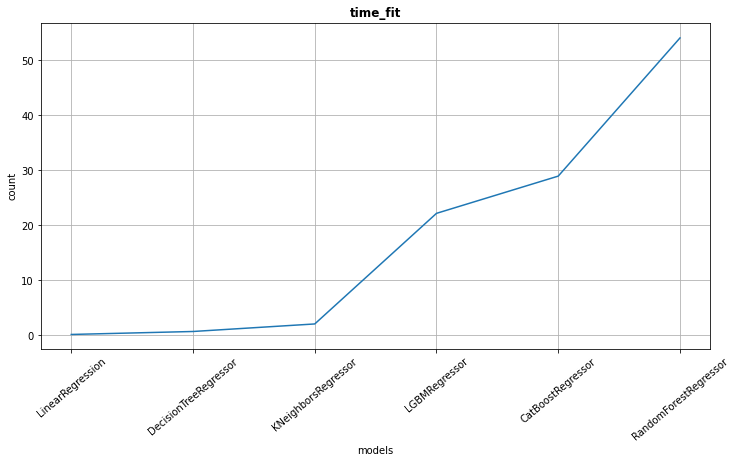

,time_fit,time_prediction,rsme
model,,,
LinearRegression,0.18,0.01,2924.77
DecisionTreeRegressor,0.72,0.01,1834.43
KNeighborsRegressor,2.09,5.05,2046.03
LGBMRegressor,22.20,7.23,1567.08
CatBoostRegressor,28.97,0.13,1600.77
RandomForestRegressor,54.09,0.92,1712.11


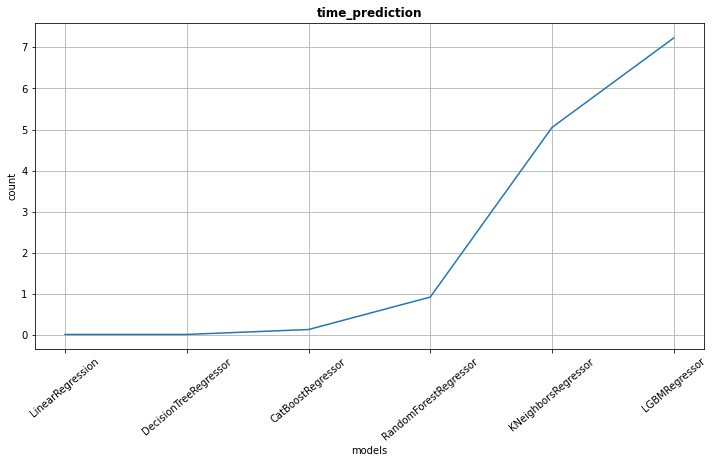

,time_fit,time_prediction,rsme
model,,,
LinearRegression,0.18,0.01,2924.77
DecisionTreeRegressor,0.72,0.01,1834.43
CatBoostRegressor,28.97,0.13,1600.77
RandomForestRegressor,54.09,0.92,1712.11
KNeighborsRegressor,2.09,5.05,2046.03
LGBMRegressor,22.20,7.23,1567.08


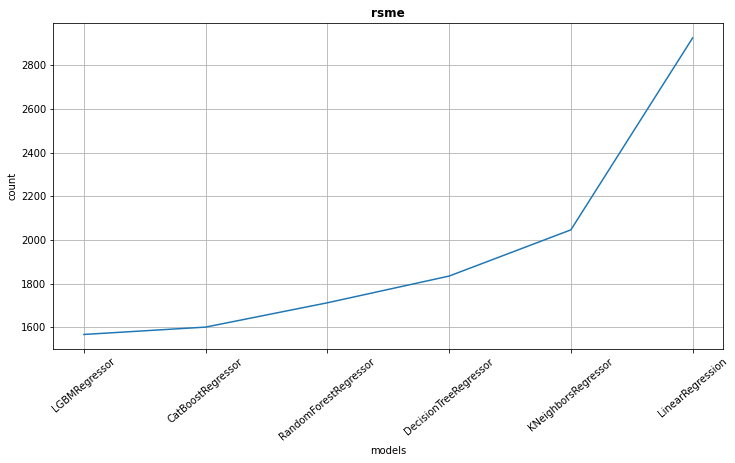

,time_fit,time_prediction,rsme
model,,,
LGBMRegressor,22.20,7.23,1567.08
CatBoostRegressor,28.97,0.13,1600.77
RandomForestRegressor,54.09,0.92,1712.11
DecisionTreeRegressor,0.72,0.01,1834.43
KNeighborsRegressor,2.09,5.05,2046.03
LinearRegression,0.18,0.01,2924.77


In [81]:
for col in df_res.columns:
    plot_helper(df_res[col].sort_values(), 'line', col, 'count', 'models')
    display(df_res.sort_values(by=col))

Лучший результат показала модель `LGBMRegressor` - с оценкой rsme 1567 временем обучения 24 секунды и временем предсказания 1,2 секунд. 

## Тестирование лучшей модели

Протестируем лучшую модель `model_lgbm от LGBMRegressor` на *тестовой выборке* предварительно обучив на *объедененной тренировочной и валидационной выборке*.

In [82]:
test_res = get_result(model_lgbm, X_train_all, X_test, y_train_all, y_test)

In [83]:
display(pd.DataFrame({test_res[0] : test_res[1:]}, index=df_res.columns).T)

,time_fit,time_prediction,rsme
LGBMRegressor,627.6,7.61,1574.11


Результаты на тестовых данных показали хорошую оценку `rsme - 1574`, которая лучше, чем на тренировочных данных, а время обучение увеличлилось потому что увеличилась выборка (трайн + тест), время предсказания почти не поменлось.

## Вывод

Данное исследование было реализовано, с целью выбора прототипа модели чтоб она предсказывала рыночную стоимость автомобиля, на основании лушей оценки rsme и времени на обучение модели и предсказания. 

Входные данные - данные содержит в себе данные об автомобилях с ценами за период `2014-2016` год, с `15 признаками и 1 целевым признаком`. Общее количество объектов - `354369`.  

**Цель проекта**
- Подготовить данные
- Провести исследовательский анализ данных
- Построить и обучить разные модели.
- Определить модель с лучшими показателми оценки rsme и затраченного времени на обучение и предсказания


**В ходе исследования:**
- Были изумены и предобработаны данные - обработаны пропуски, удалены дубликаты, переименованы признаки в соотвествии со стандартами.
- Проведен анализ признаков, в т.ч. целевого на предмет наличия в них артефактов, распределения, адекватность.
- Были обнаружены аномалии в `power`, `registration_year`, которые были обработаны в соотвествии с действительностью и наличия информации по датасету. 
- Было проведен отбор признаков, в ходе которого были добавлены 2 новых признака и далее проанализирована зависимость с целевым признаком и отобраны 9 признаков.
- Далее признаки были подготовлены для обучения модели - категориальные были преоразованы в сисла методами CountEncoder и  OHE, так же проведено масштабирование числовых признаков StandartScaler. 
- Были написаны функции для расчета оценки качества модели и замера времени в соотвествии с требованием Заказчика
- Было проведено обучение **6 моделей** - `LinearRegression`, `DecisionTreeRegressor`, `RandomForestRegressor`, `KNeighborsRegressor`, `LGBMRegressor`, `CatBoostRegressor`.

**В итоге:**   
Были выявлена определенная тенденция, где более лучшие модели по оценке rsme тратят значительно больше время на обучение, а более простые модели тратят на обучение меньше времени, но и оценка rsme у них хуже. `CatBoostRegressor`, `LGBMRegressor` тратят больше всех времени на обучение, но показывают лучшие результаты по оценке. `LGBMRegressor` потратил немного меньше времени на обучение, и показал чуть лучше оценку rsme. В итоге была выбрана модель `LGBMRegressor` и на ней проведено контрольное тестирования, которое завершилась оценками `rsme 1574` и временем на обучение	`28 сек` и временем на предсказание `7.54 сек`.  В этой лучшей модели были выявлена следующая важность признаков для предсказывания:

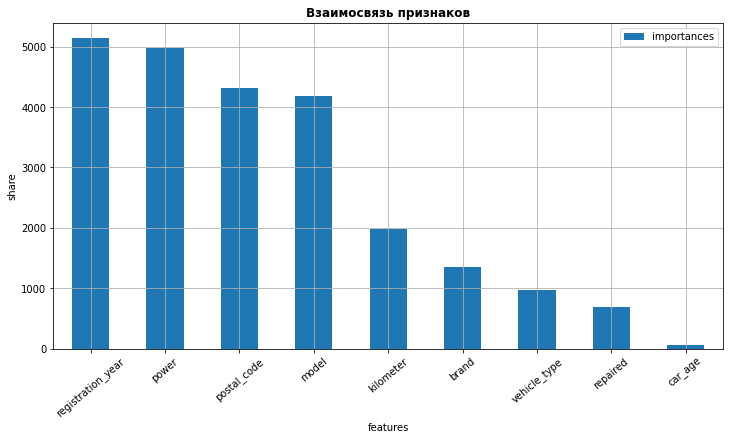

,features,importances
1,registration_year,5139
2,power,4974
7,postal_code,4310
3,model,4184
4,kilometer,1977
5,brand,1359
0,vehicle_type,980
6,repaired,692
8,car_age,56


In [84]:
df_importances = pd.DataFrame(
    {'features' : X_valid.columns,
     'importances' : np.round(model_lgbm.feature_importances_, 2)}
).sort_values(by='importances', ascending=False)

plot_helper(df_importances.set_index('features'), 'bar', 'Взаимосвязь признаков', 'share', 'features')
display(df_importances)